##### **Name:** Rohan Karthikeyan
##### **Roll number:** MDS202226

In this notebook, we will implement a recommender system based on the Entree Chicago restaurant data.
> We will work with LensKit, a Python library for training, running, and evaluating recommender algorithms.

In [1]:
# Install Lenskit
!pip install lenskit --quiet

In [2]:
# Import libraries
import pandas as pd
import numpy as np

# Import modules
from lenskit import batch, topn, util
from lenskit import crossfold as xf

from lenskit.algorithms import Recommender
from lenskit.algorithms.bias import Bias
from lenskit.algorithms.basic import Fallback

from lenskit.algorithms.ranking import TopN
from lenskit.algorithms.als import BiasedMF as MF

from lenskit.metrics.predict import rmse, user_metric

## Introduction

Entree is a **knowledge-based** recommender system (RecSys) to select and rank restaurants. It has two fundamental concepts: similarity-finding and critique-based navigation:
1. In the similarity case, Entree retrieves candidate restaurants similar to the one suggested by the user;
2. In the critique-based navigation, the candidate set is filtered for those that satisfy the user's critique.

## Goal and Hurdles

The goal of the problem is to implement a RecSys based on the Entree data. The first hurdle we encounter is that Entree is _**not**_ a collaborative filtering or a content-based RecSys. Though there exist open-source implementations of knowledge-based RecSys', Entree is different in that the low-level vocabulary used to represent each restaurant in the catalog (i.e., from Atlanta, Boston, etc.) makes it difficult to come up with a simple measure to determine similarity between restaurants.

> As an example, consider a restaurant with the feature: `Pacific New Wave` cuisine. A [Google search](https://www.latimes.com/archives/la-xpm-1990-01-22-fi-557-story.html) shows that this is an Asian-influenced cuisine, meaning that we must retrieve restaurants (in Step 1 above) that also have an Asian touch in their menus. Now, one sees that is not a simple task to encode the relation between these two cuisines.

## Approach

Due to this inherent complexity, we seek to _**reframe the problem**_ from the viewpoint of collaborative filtering. Particularly, we cast the user's navigation actions as ratings for the restaurants, inspired by Section 5.2 in [this paper](https://www.researchgate.net/publication/263377228_Hybrid_Recommender_Systems_Survey_and_Experiments) by Robin Burke, the creator of the Entree system. More details on this will be discussed below.

But for now, we start by reading in the session data of the Entree system:

## Reading and processing the data

We note that each session has a varying list of user actions. This necessitates some not-so-direct techniques to read in the data via Pandas:

In [3]:
# Read in the file
sessions = pd.read_csv('/content/new_session.txt', header=None, index_col=0,
                       delimiter='\t', names=['IP'] + list('R' + str(i) for i in range(1, 69)))

# Drop columns that have entirely null values
sessions.dropna(axis='columns', how='all', inplace=True)
sessions.fillna(np.nan, inplace=True)
sessions

<ipython-input-3-39ea17426b35>:2: DtypeWarning: Columns (31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61) have mixed types. Specify dtype option on import or set low_memory=False.
  sessions = pd.read_csv('/content/new_session.txt', header=None, index_col=0,


R1    R2    R3    R4    R5    R6    R7    R8    R9  \
IP                                                                            
www-c09.proxy.gnn.com     0  560L  110L  110X   NaN   NaN   NaN   NaN   NaN   
foley.ripco.com           0  423L   77L   77X   NaN   NaN   NaN   NaN   NaN   
foley.ripco.com           0  633N  633N  159P  159P  475X   NaN   NaN   NaN   
foley.ripco.com           0  441L  537L  537X   NaN   NaN   NaN   NaN   NaN   
pslip103d.egr-ri.ids.net  0   90M   90M   76L  476L  476X   NaN   NaN   NaN   
...                      ..   ...   ...   ...   ...   ...   ...   ...   ...   
216.176.149.182           0  100N   17N  107X   NaN   NaN   NaN   NaN   NaN   
167.165.177.216           0  274L  645L  312L  150L  322L  502L  290L  538L   
207.229.148.187           0  369L  303X   NaN   NaN   NaN   NaN   NaN   NaN   
12.75.149.51              0  369L  632L  133L  336L  378X   NaN   NaN   NaN   
205.188.197.173           0    5L   97L    5L  464X   NaN   NaN   NaN   NaN   

                           R10  ...  R52  R53  R54  R55  R56  R57  R58  R59  \
IP                              ...                                           
www-c09.proxy.gnn.com      NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
foley.ripco.com            NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
foley.ripco.com            NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
foley.ripco.com            NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
pslip103d.egr-ri.ids.net   NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
216.176.149.182            NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
167.165.177.216           287L  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
207.229.148.187            NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
12.75.149.51               NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
205.188.197.173            NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                          R60  R61  
IP                                  
www-c09.proxy.gnn.com     NaN  NaN  
foley.ripco.com           NaN  NaN  
foley.ripco.com           NaN  NaN  
foley.ripco.com           NaN  NaN  
pslip103d.egr-ri.ids.net  NaN  NaN  
...                       ...  ...  
216.176.149.182           NaN  NaN  
167.165.177.216           NaN  NaN  
207.229.148.187           NaN  NaN  
12.75.149.51              NaN  NaN  
205.188.197.173           NaN  NaN  

[50672 rows x 61 columns]

The README tells us that the entry point (here, the `R1` column) is encoded as 0 if the user does not start from a known restaurant in the catalog. We encode them as NaNs.

Next, we combine the restaurants accessed within a session in a list dropping NaNs, and then sort the data by user.

In [4]:
# Encoding the entry point
sessions['R1'] = np.where(sessions['R1'] == '0', np.nan, sessions['R1'])

# Combine the fields R1 to R61 into a list by ignoring null values
# If a value is NaN, it won't be equal to itself
sessions['All'] = [[e for e in row if e==e] for row in sessions.values.tolist()]

# Sort data by user
sessions.sort_index(inplace=True)
sessions

R1    R2    R3    R4    R5    R6    R7  \
IP                                                                         
0001527-pb1400.pixelpark.com     NaN   96L  408L  206L  308L  308X   NaN   
01-019.001.popsite.net           NaN    0L  664X   NaN   NaN   NaN   NaN   
01-019.001.popsite.net           NaN    0L  101L  237L  633L  475L  338L   
01-030.001.popsite.net           NaN  460N   -1X   NaN   NaN   NaN   NaN   
01-030.001.popsite.net          460C   17N  107N  192N  175X   NaN   NaN   
...                              ...   ...   ...   ...   ...   ...   ...   
zydeco.wharton.upenn.edu         NaN  599L  665L  643L  335L  162L  553L   
zydeco.wharton.upenn.edu         NaN  598L  220L  216L  166L  518L  483L   
zydeco.wharton.upenn.edu         NaN  560L  505L  110L  378X   NaN   NaN   
zydeco.wharton.upenn.edu         NaN  423L   77L  478L   75L  497L  133L   
zzz-209252121250.splitrock.net   NaN  400L  420X   NaN   NaN   NaN   NaN   

                                  R8    R9   R10  ...  R53  R54  R55  R56  \
IP                                                ...                       
0001527-pb1400.pixelpark.com     NaN   NaN   NaN  ...  NaN  NaN  NaN  NaN   
01-019.001.popsite.net           NaN   NaN   NaN  ...  NaN  NaN  NaN  NaN   
01-019.001.popsite.net          622L   55L  570X  ...  NaN  NaN  NaN  NaN   
01-030.001.popsite.net           NaN   NaN   NaN  ...  NaN  NaN  NaN  NaN   
01-030.001.popsite.net           NaN   NaN   NaN  ...  NaN  NaN  NaN  NaN   
...                              ...   ...   ...  ...  ...  ...  ...  ...   
zydeco.wharton.upenn.edu          3L  163L   38L  ...  NaN  NaN  NaN  NaN   
zydeco.wharton.upenn.edu        421L  391L  195X  ...  NaN  NaN  NaN  NaN   
zydeco.wharton.upenn.edu         NaN   NaN   NaN  ...  NaN  NaN  NaN  NaN   
zydeco.wharton.upenn.edu        590L   77X   NaN  ...  NaN  NaN  NaN  NaN   
zzz-209252121250.splitrock.net   NaN   NaN   NaN  ...  NaN  NaN  NaN  NaN   

                                R57  R58  R59  R60  R61  \
IP                                                        
0001527-pb1400.pixelpark.com    NaN  NaN  NaN  NaN  NaN   
01-019.001.popsite.net          NaN  NaN  NaN  NaN  NaN   
01-019.001.popsite.net          NaN  NaN  NaN  NaN  NaN   
01-030.001.popsite.net          NaN  NaN  NaN  NaN  NaN   
01-030.001.popsite.net          NaN  NaN  NaN  NaN  NaN   
...                             ...  ...  ...  ...  ...   
zydeco.wharton.upenn.edu        NaN  NaN  NaN  NaN  NaN   
zydeco.wharton.upenn.edu        NaN  NaN  NaN  NaN  NaN   
zydeco.wharton.upenn.edu        NaN  NaN  NaN  NaN  NaN   
zydeco.wharton.upenn.edu        NaN  NaN  NaN  NaN  NaN   
zzz-209252121250.splitrock.net  NaN  NaN  NaN  NaN  NaN   

                                                                              All  
IP                                                                                 
0001527-pb1400.pixelpark.com                        [96L, 408L, 206L, 308L, 308X]  
01-019.001.popsite.net                                                 [0L, 664X]  
01-019.001.popsite.net          [0L, 101L, 237L, 633L, 475L, 338L, 622L, 55L, ...  
01-030.001.popsite.net                                                [460N, -1X]  
01-030.001.popsite.net                              [460C, 17N, 107N, 192N, 175X]  
...                                                                           ...  
zydeco.wharton.upenn.edu        [599L, 665L, 643L, 335L, 162L, 553L, 3L, 163L,...  
zydeco.wharton.upenn.edu        [598L, 220L, 216L, 166L, 518L, 483L, 421L, 391...  
zydeco.wharton.upenn.edu                                 [560L, 505L, 110L, 378X]  
zydeco.wharton.upenn.edu            [423L, 77L, 478L, 75L, 497L, 133L, 590L, 77X]  
zzz-209252121250.splitrock.net                                       [400L, 420X]  

[50672 rows x 62 columns]

We now extract the last column from the above dataframe, and add them up for each unique IP address (i.e., a user) across all sessions where it has accessed the Entree system. We then create a simple user ID column and create separate rows for each restaurant the user has seen/critiqued.

Similar to how unknown entry points were encoded as 0, an unknown endpoint for a session is encoded as -1. For ease of use, I added a "X" at the end of each line in the text file, so we remove all rows with an entry of `-1X`.

In [5]:
# Combine the rating lists for each user
new = sessions[['All']].copy()
new = new.groupby(level=0).agg(sum).reset_index()

# Create user ID column
new['user'] = new.index + 1
new = new[['user', 'All', 'IP']]

# Explode the ALL column to separate rows
ratings = new.explode('All')
ratings = ratings.reset_index(drop=True)

# Entry points of 0 already marked as NaN
# Remove exit points of -1X
ratings = ratings[ratings.All != '-1X']
ratings

user   All                              IP
0           1   96L    0001527-pb1400.pixelpark.com
1           1  408L    0001527-pb1400.pixelpark.com
2           1  206L    0001527-pb1400.pixelpark.com
3           1  308L    0001527-pb1400.pixelpark.com
4           1  308X    0001527-pb1400.pixelpark.com
...       ...   ...                             ...
245961  20092  133L        zydeco.wharton.upenn.edu
245962  20092  590L        zydeco.wharton.upenn.edu
245963  20092   77X        zydeco.wharton.upenn.edu
245964  20093  400L  zzz-209252121250.splitrock.net
245965  20093  420X  zzz-209252121250.splitrock.net

[239874 rows x 3 columns]

## Provide user-restaurant ratings

The `All` column encodes user's actions (the last character) on the particular restaurant ID (specified by all but the last character). Now, in reframing our problem from the viewpoint of collaborative filtering, it is necessary to provide user-restaurant ratings.

The paper referenced above gives a cogent explanation for casting Entry and Exit actions as positive, and all other actions as negative. We instead, rescale them on a proportional 1 to 5 scale.

In [6]:
# Split 'All' column
ratings['item'] = ratings['All'].str[:-1]
ratings['rating'] = ratings['All'].str[-1]
ratings

user   All                              IP item rating
0           1   96L    0001527-pb1400.pixelpark.com   96      L
1           1  408L    0001527-pb1400.pixelpark.com  408      L
2           1  206L    0001527-pb1400.pixelpark.com  206      L
3           1  308L    0001527-pb1400.pixelpark.com  308      L
4           1  308X    0001527-pb1400.pixelpark.com  308      X
...       ...   ...                             ...  ...    ...
245961  20092  133L        zydeco.wharton.upenn.edu  133      L
245962  20092  590L        zydeco.wharton.upenn.edu  590      L
245963  20092   77X        zydeco.wharton.upenn.edu   77      X
245964  20093  400L  zzz-209252121250.splitrock.net  400      L
245965  20093  420X  zzz-209252121250.splitrock.net  420      X

[239874 rows x 5 columns]

In [7]:
# Following the paper [Section 5.2]
ratings.replace(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'], 5, inplace=True)
ratings.replace(['M', 'N', 'P', 'Q', 'R', 'S'], 1, inplace=True)
ratings.replace({'X': 4.5, 'L': 4}, inplace=True)

Now, the same restaurant can be rated more than once by the same user. Following the paper, we discard all but the most recent rating for each restaurant.

Finally, we drop rows where a user has rated only one restaurant, because it is difficult to discern the behavioural pattern of such users.

In [8]:
ratings.drop_duplicates(['user', 'item'], keep='last', inplace=True)

# Remove users who appear only once
ratings = ratings.groupby('user').filter(lambda x: len(x) > 1)

# Re-arrange the columns
ratings = ratings[['user', 'item', 'rating', 'All', 'IP']]
ratings.reset_index(drop=True, inplace=True)
ratings

user item  rating   All                              IP
0           1   96     4.0   96L    0001527-pb1400.pixelpark.com
1           1  408     4.0  408L    0001527-pb1400.pixelpark.com
2           1  206     4.0  206L    0001527-pb1400.pixelpark.com
3           1  308     4.5  308X    0001527-pb1400.pixelpark.com
4           2  664     4.5  664X          01-019.001.popsite.net
...       ...  ...     ...   ...                             ...
178559  20092  133     4.0  133L        zydeco.wharton.upenn.edu
178560  20092  590     4.0  590L        zydeco.wharton.upenn.edu
178561  20092   77     4.5   77X        zydeco.wharton.upenn.edu
178562  20093  400     4.0  400L  zzz-209252121250.splitrock.net
178563  20093  420     4.5  420X  zzz-209252121250.splitrock.net

[178564 rows x 5 columns]

## Generate and evaluate recommendations

In this section, we will run an alternating least squares implementation of matrix factorization to generate recommendations.

### Preparing for evaluation
In LensKit, evaluation proceeds in 2 steps:
- Generate recommendations
- Measure them

Not all algorithms generate recommendations, hence we wrap it with `TopN`. This is a basic recommender that implements top-N recommendation using a predictor.

In [9]:
def evaluate(train, test, algo):
    '''
    Generate recommendations over a single partition of the data set.

    Returns:
    -------
    recs (pd.DataFrame): A dataframe of of recommendations
    '''
    cloned_algo = util.clone(algo)  # Clone the algorithm, not its fitted data
    fittable = TopN(cloned_algo)
    fittable.fit(train)  # Fit the training set

    # Get 50 recommendations for all users in test set
    users_to_rec = test.user.unique()
    recs = batch.recommend(algo=fittable, users=users_to_rec, n=50)
    return recs

### Generate recommendations
To prepare data sets for cross-validation, we use the `partition_users` function: this splits the dataframe into train and test splits on a user-by-user basis.
The algorithm used is as follows:

1. Sample or partition the set of user IDs into $n$ sets of test users (here, $n = 10$).
2. For each set of test users, select a set of that user's rows to be test rows.
3. Create a training set for each test set consisting of the non-selected rows from each of that set's test users, along with all rows from each non-test user.

We randomly select a fraction (here, 15%) of test rows per user/item.

In [10]:
# Our algorithm: Perform alternating least squares with 40 features
als = MF(features=40)

In [11]:
%%time
test_data = []

for train, test in xf.partition_users(data=ratings[['user', 'item', 'rating']],
                                      partitions=10, method=xf.SampleFrac(0.15)):
    test_data.append(test)
    recs = evaluate(train, test, als)  # Run the evaluation fn.

# Get first few rows of recommendations
recs.head(10)

CPU times: user 3min 19s, sys: 1min 57s, total: 5min 17s
Wall time: 3min 21s


item     score  user  rank
0   91  5.061989     6     1
1  108  4.939753     6     2
2  140  4.891931     6     3
3  558  4.756156     6     4
4   26  4.735772     6     5
5  626  4.717489     6     6
6  900  4.705498     6     7
7  253  4.695900     6     8
8  495  4.681552     6     9
9  487  4.674159     6    10

### Evaluate recommendations
We require two data frames for analysis:
- The recommendation frame contains the recommendations themselves, and
- The truth frame contains the ground truth data for the users.

We analyze our recommendation lists with a `RecListAnalysis`. This takes care of the hard work of making sure that the truth data (our test data) and the recommendations line up properly.

In [12]:
rla = topn.RecListAnalysis()

# Add metrics for computing precision and recall
# Consider only top 15 recommendations for evaluation
rla.add_metric(topn.precision, k=15)
rla.add_metric(topn.recall, k=15)

# Concatenate test data for evaluation
test_data = pd.concat(test_data, ignore_index=True)

# Run the analysis
results = rla.compute(recs, test_data)
results

nrecs  precision  recall
user                           
6         50   0.000000     0.0
11        50   0.000000     0.0
12        50   0.000000     0.0
13        50   0.000000     0.0
30        50   0.000000     0.0
...      ...        ...     ...
20056     50   0.000000     0.0
20065     50   0.066667     1.0
20073     50   0.000000     0.0
20081     50   0.000000     0.0
20084     50   0.000000     0.0

[1278 rows x 3 columns]

<Axes: xlabel='precision', ylabel='recall'>

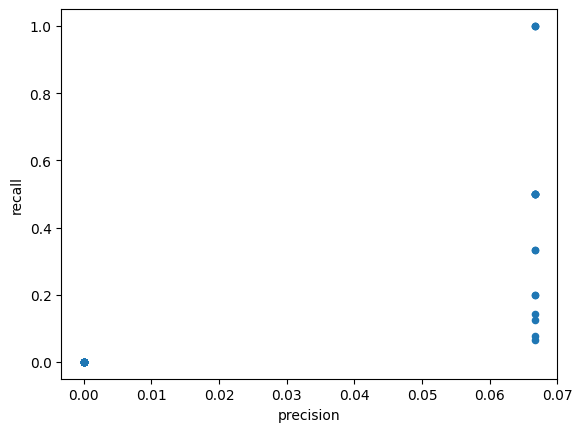

In [13]:
# Scatter plot
results.plot(x='precision', y='recall', kind='scatter')

## Generate and evaluate predictions

We use a random 15% of the data as our test set and use the remaining for training.

Sometimes, when the core model (here, the ALS algo.) is unable to predict, it returns a NaN for the predicted rating. This is a problem when computing predictive accuracy: recommenders are not being tested on the same set of items.

To solve this problem, LensKit advises to use a fallback predictor so that every item will have a prediction: it takes a list of composite algorithms, and uses the first one to return a result to predict the rating for each item.

We employ a `Bias` predictor as our fallback: it gives a personalized mean rating prediction.

In [14]:
%%time
from sklearn.model_selection import train_test_split

# Make the train-test split
train, test = train_test_split(ratings, test_size=0.15,
                               stratify=ratings['user'])

# Fit our SVD algorithm
base = Bias(damping=5)
algo = Fallback(als, base)
algo.fit(train)

# Compute predictions
preds = batch.predict(algo, test)
preds

CPU times: user 48.9 s, sys: 4.22 s, total: 53.1 s
Wall time: 50.5 s


user item  rating   All                           IP  prediction
175786  19845  265     1.0  265Q        www-as9.proxy.aol.com    2.617455
16184    2055  336     4.0  336L              152.163.207.201    3.983211
108171  13088  356     1.0  356N        houasc31-37.flash.net    3.504307
130530  15550  101     4.0  101L        pm0-16.bluemarble.net    3.985189
105823  12773  560     4.0  560L        hb-to01.proxy.aol.com    3.224051
...       ...  ...     ...   ...                          ...         ...
27906    3487  205     4.0  205L              194.196.220.129    2.567152
149452  17801  462     4.5  462X   spider-th032.proxy.aol.com    3.482107
11860    1527  230     4.0  230L               144.74.111.196    2.613447
51696    6382  107     1.0  107N                207.0.136.109    2.124455
68554    8594   17     1.0   17N  225ohiomax3-62.megsinet.net    2.306750

[26785 rows x 6 columns]

In [15]:
# Calculate global RMSE
global_rmse = rmse(preds['prediction'], preds['rating'])
print('The global RMSE of the model is {:.3f}.'.format(global_rmse))

# Calculate mean of per-user RMSE
mean_user_rmse = user_metric(preds, metric=rmse)
print('The mean per-user RMSE of the model is {:.3f}.'.format(mean_user_rmse))

The global RMSE of the model is 1.182.
The mean per-user RMSE of the model is 0.948.
